In [1]:
import pandas as pd
import numpy as np

## Data Preparation

Steps:
- read in 200K lines of original csv with just **['COMMON NAME', 'COUNTRY', 'STATE', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'OBSERVATION COUNT']** columns
- rename columns for easier working
- replace 'X' with 1 in **observ_count** column
- filter just birds in 'United States'
- drop rows with NaN in **county**
- convert **OBSERVATION DATE** to datetime
- extract month and year from **OBSERVATION DATE** into their own columns
- **'season'** column from month
- **county_state** column to merge on, no space
- load region excel file
- strip leading whitespace from **State**
- drop numbers from **RegionName**
- Alaska has strange county names; map them to match the birds **county names**
- Louisiana has 'parish' attached to **county names**, clean those like 'county' below
- Capitalize 'city' for St. Louis and Richmond counties <- current plan is using df.at but that's too hardcoded, would like better way
- drop 'county' from **CountyName**
- merge on county
- **counts** Series with percentage of each bird
- **total_rarity** column mapped from **counts**
- **regional_rarity** from counts split by region
- **seasonal_rarity** from counts by region and season
- **rarity_label** if any of the three comes out as rare

In [2]:
# Step 1: Read in the first 200K lines, with 8 columns
df = pd.read_csv('C:\\Users\\ajaco\\Downloads\\ebd_relJan-2020.txt', sep='\t', nrows=200000, usecols=['COMMON NAME', 'COUNTRY', 'STATE', 'COUNTY', 'LATITUDE', 'LONGITUDE', 'OBSERVATION DATE', 'OBSERVATION COUNT'])

print(df.shape)

df.head()

(200000, 8)


,COMMON NAME,OBSERVATION COUNT,COUNTRY,STATE,COUNTY,LATITUDE,LONGITUDE,OBSERVATION DATE
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27
1,White-rumped Sandpiper,4,Canada,Quebec,Manicouagan,49.216670,-68.150000,1993-11-07
2,Common Scoter,1,Sweden,Hallands län [SE-13],NaN,57.065084,12.243579,1998-02-21
3,Ring-billed Gull,15,Canada,Manitoba,South Interlake,50.193256,-97.137935,1985-04-14
4,Red-winged Blackbird,500,Canada,Manitoba,South Interlake,50.193256,-97.137935,1986-09-01


In [3]:
df.isnull().sum()

COMMON NAME              0
OBSERVATION COUNT        0
COUNTRY                  0
STATE                    0
COUNTY               29261
LATITUDE                 0
LONGITUDE                0
OBSERVATION DATE         0
dtype: int64

In [4]:
# Rename columns for ease of use
df.rename(columns={
    'COMMON NAME': 'name',
    'OBSERVATION COUNT': 'observ_count',
    'COUNTRY': 'country',
    'STATE': 'state',
    'COUNTY': 'county',
    'LATITUDE': 'latitude',
    'LONGITUDE': 'longitude',
    'OBSERVATION DATE': 'observ_date'
}, inplace=True)

In [5]:
df.head()

,name,observ_count,country,state,county,latitude,longitude,observ_date
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27
1,White-rumped Sandpiper,4,Canada,Quebec,Manicouagan,49.216670,-68.150000,1993-11-07
2,Common Scoter,1,Sweden,Hallands län [SE-13],NaN,57.065084,12.243579,1998-02-21
3,Ring-billed Gull,15,Canada,Manitoba,South Interlake,50.193256,-97.137935,1985-04-14
4,Red-winged Blackbird,500,Canada,Manitoba,South Interlake,50.193256,-97.137935,1986-09-01


In [6]:
# Filter for just US birds
us_birds = df.query("country == 'United States'")

print(us_birds.shape)
us_birds.head()

(105294, 8)


,name,observ_count,country,state,county,latitude,longitude,observ_date
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27
6,Greater Yellowlegs,X,United States,Texas,Aransas,28.240392,-96.818819,1986-04-06
12,White-crowned Sparrow,X,United States,Arizona,Cochise,31.898164,-109.115932,1998-11-27
13,Green-winged Teal,11,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18
14,Yellow-rumped Warbler,5,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18


In [7]:
#217 birds are missing 
us_birds.isnull().sum()

name              0
observ_count      0
country           0
state             0
county          217
latitude          0
longitude         0
observ_date       0
dtype: int64

In [8]:
# Drop missing column values
us_birds.dropna(subset=['county'], inplace=True)

us_birds.isnull().sum()

C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


name            0
observ_count    0
country         0
state           0
county          0
latitude        0
longitude       0
observ_date     0
dtype: int64

In [9]:
# Replace 'X' in 'observ_count' with 1
us_birds['observ_count'] = us_birds['observ_count'].apply(lambda x: 1 if x == 'X' else x)

us_birds.head()

C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,observ_count,country,state,county,latitude,longitude,observ_date
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27
6,Greater Yellowlegs,1,United States,Texas,Aransas,28.240392,-96.818819,1986-04-06
12,White-crowned Sparrow,1,United States,Arizona,Cochise,31.898164,-109.115932,1998-11-27
13,Green-winged Teal,11,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18
14,Yellow-rumped Warbler,5,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18


In [10]:
# Convert 'observ_date' to datetime and extract year and month
us_birds.observ_date = pd.to_datetime(us_birds['observ_date'], infer_datetime_format=True)
us_birds['year'] = us_birds.observ_date.dt.year
us_birds['month'] = us_birds.observ_date.dt.month

C:\Users\ajaco\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [11]:
us_birds.columns

Index(['name', 'observ_count', 'country', 'state', 'county', 'latitude',
       'longitude', 'observ_date', 'year', 'month'],
      dtype='object')

In [12]:
us_birds.dtypes

name                    object
observ_count            object
country                 object
state                   object
county                  object
latitude               float64
longitude              float64
observ_date     datetime64[ns]
year                     int64
month                    int64
dtype: object

In [13]:
us_birds.isnull().sum()

name            0
observ_count    0
country         0
state           0
county          0
latitude        0
longitude       0
observ_date     0
year            0
month           0
dtype: int64

In [14]:
# 'season' column from month values
def month_to_season(x):
    if x in [12, 1, 2]:
        return 'Winter'
    elif x in [3, 4, 5]:
        return 'Spring'
    elif x in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

us_birds['season'] = us_birds['month'].apply(month_to_season)
us_birds.head()

C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,name,observ_count,country,state,county,latitude,longitude,observ_date,year,month,season
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27,1995,8,Summer
6,Greater Yellowlegs,1,United States,Texas,Aransas,28.240392,-96.818819,1986-04-06,1986,4,Spring
12,White-crowned Sparrow,1,United States,Arizona,Cochise,31.898164,-109.115932,1998-11-27,1998,11,Fall
13,Green-winged Teal,11,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18,1982,12,Winter
14,Yellow-rumped Warbler,5,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18,1982,12,Winter


In [15]:
us_birds.season.value_counts()

Spring    39610
Summer    25783
Fall      22449
Winter    17235
Name: season, dtype: int64

In [17]:
# Create merge column
us_birds['county_state'] = us_birds['county'] + us_birds['state']

us_birds.head()

C:\Users\ajaco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,observ_count,country,state,county,latitude,longitude,observ_date,year,month,season,county_state
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27,1995,8,Summer,CookIllinois
6,Greater Yellowlegs,1,United States,Texas,Aransas,28.240392,-96.818819,1986-04-06,1986,4,Spring,AransasTexas
12,White-crowned Sparrow,1,United States,Arizona,Cochise,31.898164,-109.115932,1998-11-27,1998,11,Fall,CochiseArizona
13,Green-winged Teal,11,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18,1982,12,Winter,AdaIdaho
14,Yellow-rumped Warbler,5,United States,Idaho,Ada,43.609793,-116.206427,1982-12-18,1982,12,Winter,AdaIdaho


In [18]:
# Checking county name data
us_birds.query("county == 'Los Angeles'")

,name,observ_count,country,state,county,latitude,longitude,observ_date,year,month,season,county_state
500,Hutton's Vireo,1,United States,California,Los Angeles,34.217551,-118.162250,1982-05-30,1982,5,Spring,Los AngelesCalifornia
1467,Glaucous-winged Gull,5,United States,California,Los Angeles,34.005131,-118.807549,1994-12-18,1994,12,Winter,Los AngelesCalifornia
1816,Lesser Goldfinch,10,United States,California,Los Angeles,34.005131,-118.807549,1980-01-15,1980,1,Winter,Los AngelesCalifornia
1817,American Goldfinch,30,United States,California,Los Angeles,34.005131,-118.807549,1980-01-15,1980,1,Winter,Los AngelesCalifornia
2291,Rock Pigeon,15,United States,California,Los Angeles,34.005131,-118.807549,1982-05-29,1982,5,Spring,Los AngelesCalifornia
...,...,...,...,...,...,...,...,...,...,...,...,...
198434,White-headed Woodpecker,1,United States,California,Los Angeles,34.326745,-118.004714,1995-11-24,1995,11,Fall,Los AngelesCalifornia
198586,Hooded Oriole,1,United States,California,Los Angeles,34.056010,-118.246332,1997-05-02,1997,5,Spring,Los AngelesCalifornia
198706,Mourning Dove,8,United States,California,Los Angeles,34.082415,-118.503149,1978-05-29,1978,5,Spring,Los AngelesCalifornia
199581,Townsend's Warbler,2,United States,California,Los Angeles,34.056010,-118.246332,1996-11-26,1996,11,Fall,Los AngelesCalifornia


In [19]:
# Read in regions df
regions = pd.read_excel("C:\\Users\\ajaco\\Desktop\\repos\\noreallyimfine\\ebird-project\\URAmericaMapCountyList.xlsx", skiprows=3, usecols=['State', 'CountyName', 'RegionName'])

print(regions.shape)

regions.head()

(3142, 3)


,State,CountyName,RegionName
0,Alabama,"Autauga County, Alabama",01 Deep South
1,Alabama,"Baldwin County, Alabama",03 Gulf Coast
2,Alabama,"Barbour County, Alabama",01 Deep South
3,Alabama,"Bibb County, Alabama",02 Appohzarka
4,Alabama,"Blount County, Alabama",02 Appohzarka


In [20]:
regions.State.unique()

array([' Alabama', ' Alaska', ' Arizona', ' Arkansas', ' California',
       ' Colorado', ' Connecticut', ' Delaware', ' District of Columbia',
       ' Florida', ' Georgia', ' Hawaii', ' Idaho', ' Illinois',
       ' Indiana', ' Iowa', ' Kansas', ' Kentucky', ' Louisiana',
       ' Maine', ' Maryland', ' Massachusetts', ' Michigan', ' Minnesota',
       ' Mississippi', ' Missouri', ' Montana', ' Nebraska', ' Nevada',
       ' New Hampshire', ' New Jersey', ' New Mexico', ' New York',
       ' North Carolina', ' North Dakota', ' Ohio', ' Oklahoma',
       ' Oregon', ' Pennsylvania', ' Rhode Island', ' South Carolina',
       ' South Dakota', ' Tennessee', ' Texas', ' Utah', ' Vermont',
       ' Virginia', ' Washington', ' West Virginia', ' Wisconsin',
       ' Wyoming'], dtype=object)

In [21]:
# Strip leading whitespace
regions.State = regions.State.str.strip()

regions.State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [22]:
# Split region numbers off RegionName
regions['RegionName'] = regions['RegionName'].apply(lambda x: ' '.join(x.split()[1:]))

In [23]:
# Split state name off county
regions['CountyName'] = regions['CountyName'].apply(lambda x: x.split(',')[0])

regions.head()

,State,CountyName,RegionName
0,Alabama,Autauga County,Deep South
1,Alabama,Baldwin County,Gulf Coast
2,Alabama,Barbour County,Deep South
3,Alabama,Bibb County,Appohzarka
4,Alabama,Blount County,Appohzarka


In [24]:
regions.CountyName.nunique()

1877

In [27]:
# Change Alaska county names to match birds counties
county_dict = {
    'Aleutians East Borough': 'Aleutians East',
    'Aleutians West Census Area': 'Aleutians West',
    'Anchorage Municipality': 'Anchorage',
    'Bethel Census Area': 'Bethel',
    'Bristol Bay Borough': 'Bristol Bay',
    'Denali Borough': 'Denali',
    'Dillingham Census Area': 'Dillingham',
    'Fairbanks North Star Borough': 'Fairbanks North Star',
    'Haines Borough': 'Haines',
    'Hoonah-Angoon Census Area': 'Skagway-Hoonah-Angoon',
    'Juneau City and Borough': 'Juneau',
    'Kenai Peninsula Borough': 'Kenai Peninsula',
    'Ketchikan Gateway Borough': 'Ketchikan Gateway',
    'Kodiak Island Borough': 'Kodiak Island',
    'Kusilvak Census Area': 'Kusilvak',
    'Lake and Peninsula Borough': 'Lake and Peninsula',
    'Matanuska-Susitna Borough': 'Matanuska-Susitna',
    'Nome Census Area': 'Nome',
    'North Slope Borough': 'North Slope',
    'Northwest Arctic Borough': 'Northwest Arctic',
    'Petersburg Borough': 'Petersburg Borough',
    'Prince of Wales-Hyder Census Area': 'Prince of Wales-Outer Ketchikan',
    'Sitka City and Borough': 'Sitka',
    'Southeast Fairbanks Census Area': 'Southeast Fairbanks',
    'Valdez-Cordova Census Area': 'Valdez-Cordova',
    'Yakutat City and Borough': 'Yakutat',
    'Yukon-Koyukuk Census Area': 'Yukon-Koyukuk'
}

regions['CountyName'] = regions['CountyName'].apply(lambda x: county_dict[x] if x in county_dict.keys() else x)
regions.CountyName.nunique()

1877

In [28]:
# Remove 'Parish' from CountyName
regions['CountyName'] = regions['CountyName'].apply(lambda x: x if 'Parish' not in x else ' '.join(x.split()[:-1]))
regions.query("State == 'Louisiana'")

,State,CountyName,RegionName
1113,Louisiana,Acadia,Gulf Coast
1114,Louisiana,Allen,Deep South
1115,Louisiana,Ascension,Gulf Coast
1116,Louisiana,Assumption,Gulf Coast
1117,Louisiana,Avoyelles,Gulf Coast
...,...,...,...
1172,Louisiana,Webster,Deep South
1173,Louisiana,West Baton Rouge,Gulf Coast
1174,Louisiana,West Carroll,Deep South
1175,Louisiana,West Feliciana,Gulf Coast


In [29]:
# Capitalize 'city' in 'Richmond city'
print(regions.at[2944, 'CountyName'])
regions.at[2944, 'CountyName'] = 'Richmond City'
regions.at[2944, 'CountyName']

Richmond city


'Richmond City'

In [30]:
# Capitalize 'city' in 'St. Louis city'
print(regions.at[1597, 'CountyName'])
regions.at[1597, 'CountyName'] = 'St. Louis City'
regions.at[1597, 'CountyName']

St. Louis city


'St. Louis City'

In [31]:
# Remove 'city' from Virginia counties
# regions['CountyName'] = regions['CountyName'].apply(lambda x: x if 'city' not in x else ' '.join(x.split()[:-1]))
# regions.query("State == 'Virginia'")

In [32]:
# Split off 'county' from name
regions['CountyName'] = regions['CountyName'].apply(lambda x: x if 'County' not in x else ' '.join(x.split()[:-1]))

regions.head()

,State,CountyName,RegionName
0,Alabama,Autauga,Deep South
1,Alabama,Baldwin,Gulf Coast
2,Alabama,Barbour,Deep South
3,Alabama,Bibb,Appohzarka
4,Alabama,Blount,Appohzarka


In [33]:
regions.query("CountyName == 'Los Angeles'")

,State,CountyName,RegionName
204,California,Los Angeles,West Coast


In [34]:
# Combine 'county' and 'state' for merge
regions['county_state'] = regions['CountyName'] + regions.State

In [35]:
regions.head()

,State,CountyName,RegionName,county_state
0,Alabama,Autauga,Deep South,AutaugaAlabama
1,Alabama,Baldwin,Gulf Coast,BaldwinAlabama
2,Alabama,Barbour,Deep South,BarbourAlabama
3,Alabama,Bibb,Appohzarka,BibbAlabama
4,Alabama,Blount,Appohzarka,BlountAlabama


In [36]:
us_birds.shape

(105077, 12)

In [37]:
merged = us_birds.merge(regions)
merged.shape

(104732, 15)

Up to merging step. losing 3500 rows on merge, must figure out why

- Alasks was the first culprit, figured that out but still losing ~2K rows
- Louisiana has 'parish' at the end of the county names, clean those up
- Capitalize 'city' in ['Richmond city', 'St. Louis city']
- Leave Virginia 'city' alone for rest of counties because it messes up the merg

Moving on, got lost rows down to 300

In [331]:
reg_set = set(regions.county_state.tolist())
us_set = set(us_birds.county_state.tolist())

extra = []
for key in us_set:
    if key not in reg_set:
        extra.append(key)

In [332]:
extra

['ManassasVirginia',
 'AlexandriaVirginia',
 'Wrangell-PetersburgAlaska',
 'SuffolkVirginia',
 'Dona AnaNew Mexico',
 'HopewellVirginia',
 'Virginia BeachVirginia',
 'SalemVirginia',
 'WilliamsburgVirginia',
 'Newport NewsVirginia',
 'RadfordVirginia',
 'HamptonVirginia',
 'NorfolkVirginia',
 'Buena VistaVirginia',
 'HarrisonburgVirginia',
 'La SalleLouisiana',
 'LynchburgVirginia',
 'DanvilleVirginia',
 'CharlottesvilleVirginia',
 'La SalleIllinois',
 'Falls ChurchVirginia']

In [333]:
merged.shape

(104732, 15)

In [39]:
counts = merged.name.value_counts(normalize=True)
counts

Mourning Dove                  0.015965
American Robin                 0.014781
American Crow                  0.014523
European Starling              0.013568
Song Sparrow                   0.013520
                                 ...   
Mallard/American Black Duck    0.000010
Northern Jacana                0.000010
Rosy-billed Pochard            0.000010
Red-flanked Bluetail           0.000010
Cliff/Cave Swallow             0.000010
Name: name, Length: 917, dtype: float64

In [40]:
# Bird rarity as a function of total bird sightings
def rare_bird(x):
    bird_percent = counts[x]
    if bird_percent > 0.001:
        return "Common"
    elif bird_percent > 0.00001:
        return "Uncommon"
    else:
        return "Rare"

merged['bird_rarity'] = merged['name'].apply(rare_bird)
merged.bird_rarity.value_counts(normalize=True)

Common      0.864206
Uncommon    0.134658
Rare        0.001136
Name: bird_rarity, dtype: float64

In [41]:
merged.columns

Index(['name', 'observ_count', 'country', 'state', 'county', 'latitude',
       'longitude', 'observ_date', 'year', 'month', 'season', 'county_state',
       'State', 'CountyName', 'RegionName', 'bird_rarity'],
      dtype='object')

In [76]:
# Bird rarity as a function of region

# look at value_counts by region, normalized
region_freq_ct = pd.crosstab(merged['name'], values=merged['name'], columns=merged['RegionName'], aggfunc='count', normalize='columns')


def regional_rare_bird(x, y):
    bird_percent = region_freq_ct.loc[x][y]
    print(x,y, bird_percent)
    if bird_percent > 0.005:
        return "Common"
    elif bird_percent > 0.0005:
        return "Uncommon"
    else:
        return "Rare"
    
merged['region_rarity'] = merged.apply(lambda x: regional_rare_bird(x['name'], x['RegionName']), axis=1)
merged.head()

Magnolia Warbler Great Lakes 0.004030940189563134
Great Blue Heron Great Lakes 0.010022878309184007
Purple Martin Great Lakes 0.0032683298834295673
Common Yellowthroat Great Lakes 0.008497657696916875
Eastern Towhee Great Lakes 0.005011439154592004
House Wren Great Lakes 0.0072992700729927005
Common Grackle Great Lakes 0.016232705087700184
Mallard Great Lakes 0.01982786795947271
Savannah Sparrow Great Lakes 0.003921995860115481
Horned Lark Great Lakes 0.0028325525656389583
Gray-cheeked Thrush Great Lakes 0.0006536659766859135
Yellow-bellied Sapsucker Great Lakes 0.004030940189563134
Brown Thrasher Great Lakes 0.004466717507353743
Dark-eyed Junco Great Lakes 0.010022878309184007
Brown Creeper Great Lakes 0.005447216472382613
Ring-necked Pheasant Great Lakes 0.0028325525656389583
Eastern Bluebird Great Lakes 0.0053382721429349606
Broad-winged Hawk Great Lakes 0.001743109271162436
Northern Cardinal Great Lakes 0.01841159167665323
Northern Flicker Great Lakes 0.012528597886480008
Hairy Woo

KeyboardInterrupt: 

In [74]:
merged.region_rarity.value_counts(normalize=True)

Common      0.569931
Uncommon    0.402628
Rare        0.027441
Name: region_rarity, dtype: float64

In [77]:
merged.head()

,name,observ_count,country,state,county,latitude,longitude,observ_date,year,month,season,county_state,State,CountyName,RegionName,bird_rarity,region_rarity
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27,1995,8,Summer,CookIllinois,Illinois,Cook,Great Lakes,Common,Uncommon
1,Great Blue Heron,2,United States,Illinois,Cook,41.956746,-87.913027,1999-07-24,1999,7,Summer,CookIllinois,Illinois,Cook,Great Lakes,Common,Common
2,Purple Martin,6,United States,Illinois,Cook,41.707907,-87.886848,1965-06-19,1965,6,Summer,CookIllinois,Illinois,Cook,Great Lakes,Common,Uncommon
3,Common Yellowthroat,3,United States,Illinois,Cook,41.707907,-87.886848,1965-06-19,1965,6,Summer,CookIllinois,Illinois,Cook,Great Lakes,Common,Common
4,Eastern Towhee,3,United States,Illinois,Cook,41.707907,-87.886848,1965-06-19,1965,6,Summer,CookIllinois,Illinois,Cook,Great Lakes,Common,Common


In [127]:
# Bird rarity as a function of region and season

#table = pd.pivot_table(df, values='D', index=['A', 'B'],
                   # columns=['C'], aggfunc=np.sum)
season_region_ct = pd.pivot_table(merged, index='name', columns=['RegionName', 'season'], values='observ_count', aggfunc='count', fill_value=0.0)
season_region_ct

RegionName                                         Appohzarka                \
season                                                   Fall Spring Summer   
name                                                                          
Abert's Towhee                                              0      0      0   
Acadian Flycatcher                                          1     10     12   
Accipiter sp.                                               1      0      0   
Acorn Woodpecker                                            0      0      0   
African Collared-Dove (Domestic type or Ringed ...          0      0      0   
...                                                       ...    ...    ...   
warbler sp. (Parulidae sp.)                                 0      0      1   
white egret sp.                                             0      0      0   
woodpecker sp.                                              0      0      0   
wren sp.                                                    0      0      0   
yellow-bellied kingbird sp.                                 0      0      0   

RegionName                                                Deep South         \
season                                             Winter       Fall Spring   
name                                                                          
Abert's Towhee                                          0          0      0   
Acadian Flycatcher                                      0          1     13   
Accipiter sp.                                           0          0      0   
Acorn Woodpecker                                        0          0      0   
African Collared-Dove (Domestic type or Ringed ...      0          0      0   
...                                                   ...        ...    ...   
warbler sp. (Parulidae sp.)                             0          0      0   
white egret sp.                                         0          0      0   
woodpecker sp.                                          0          0      0   
wren sp.                                                0          0      0   
yellow-bellied kingbird sp.                             0          0      0   

RegionName                                                       Great Lakes  \
season                                             Summer Winter        Fall   
name                                                                           
Abert's Towhee                                          0      0           0   
Acadian Flycatcher                                      3      0           1   
Accipiter sp.                                           0      1           1   
Acorn Woodpecker                                        0      0           0   
African Collared-Dove (Domestic type or Ringed ...      0      0           0   
...                                                   ...    ...         ...   
warbler sp. (Parulidae sp.)                             0      0           0   
white egret sp.                                         0      0           0   
woodpecker sp.                                          0      0           0   
wren sp.                                                0      0           0   
yellow-bellied kingbird sp.                             0      0           0   

RegionName                                                 ...  \
season                                             Spring  ...   
name                                                       ...   
Abert's Towhee                                          0  ...   
Acadian Flycatcher                                      6  ...   
Accipiter sp.                                           0  ...   
Acorn Woodpecker                                        0  ...   
African Collared-Dove (Domestic type or Ringed ...      0  ...   
...                                                   ...  ...   
warbler sp. (Parulidae sp.)                             1  ...   
white

In [142]:
season_region_ct[('Appohzarka', 'Fall')].value_counts(normalize=True)

0     0.723010
1     0.059978
2     0.033806
3     0.029444
4     0.026172
8     0.019629
7     0.015267
5     0.011996
9     0.008724
6     0.008724
13    0.007634
10    0.007634
21    0.004362
16    0.004362
11    0.003272
12    0.003272
24    0.003272
23    0.003272
17    0.003272
18    0.003272
19    0.003272
14    0.002181
20    0.002181
22    0.002181
26    0.002181
53    0.001091
50    0.001091
28    0.001091
36    0.001091
37    0.001091
42    0.001091
15    0.001091
Name: (Appohzarka, Fall), dtype: float64

In [122]:
pd.crosstab(index=merged['name'], columns=merged[['RegionName', 'season']],values=merged['name'], aggfunc='count')

ValueError: could not broadcast input array from shape (2) into shape (104732)

In [98]:
#season_region_ct.columns
print(merged.RegionName.nunique())

14


In [48]:
columns = region_freq_ct.columns

for column in columns:
    print(f'Value Counts of {column}')
    print(region_freq_ct[column].value_counts(normalize=True))

Value Counts of Appohzarka
0.000000    0.641221
0.000118    0.040349
0.000235    0.022901
0.000353    0.020720
0.000470    0.018539
              ...   
0.020212    0.001091
0.007638    0.001091
0.012338    0.001091
0.006110    0.001091
0.022444    0.001091
Name: Appohzarka, Length: 89, dtype: float64
Value Counts of Deep South
0.000000    0.603053
0.000112    0.058888
0.000225    0.032715
0.000337    0.016358
0.000562    0.016358
              ...   
0.003258    0.001091
0.005393    0.001091
0.009100    0.001091
0.007640    0.001091
0.007078    0.001091
Name: Deep South, Length: 87, dtype: float64
Value Counts of Great Lakes
0.000000    0.627045
0.000109    0.058888
0.000218    0.021810
0.000327    0.020720
0.000654    0.015267
              ...   
0.016451    0.001091
0.008498    0.001091
0.008280    0.001091
0.018956    0.001091
0.016233    0.001091
Name: Great Lakes, Length: 87, dtype: float64
Value Counts of Great Plains
0.000000    0.574700
0.000218    0.088332
0.000436    0.0545

In [348]:
region_freq_ct.describe()

RegionName,Appohzarka,Deep South,Great Lakes,Great Plains,Gulf Coast,Heartland,Mid-Atlantic North,Mid-Atlantic South,Mountain West,Northeast,Northwest,Southern Florida,Southwest,West Coast
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091,0.001091
std,0.002751,0.002618,0.002903,0.002485,0.002387,0.002975,0.002909,0.002527,0.002323,0.002568,0.002477,0.002809,0.002086,0.002283
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000099,0.000000,0.000000,0.000000,0.000141,0.000135
75%,0.000588,0.000674,0.000545,0.000871,0.001025,0.000416,0.000518,0.000888,0.000990,0.000757,0.000713,0.000356,0.001130,0.000947
max,0.022444,0.022806,0.021898,0.025926,0.019739,0.023301,0.023750,0.021532,0.017130,0.020261,0.021509,0.017781,0.017370,0.020168


In [345]:
region_freq_ct[region_freq_ct['Appohzarka'] ] 

name
Abert's Towhee                                                 0.000000
Acadian Flycatcher                                             0.002703
Accipiter sp.                                                  0.000118
Acorn Woodpecker                                               0.000000
African Collared-Dove (Domestic type or Ringed Turtle-Dove)    0.000000
                                                                 ...   
warbler sp. (Parulidae sp.)                                    0.000118
white egret sp.                                                0.000000
woodpecker sp.                                                 0.000000
wren sp.                                                       0.000000
yellow-bellied kingbird sp.                                    0.000000
Name: Appohzarka, Length: 917, dtype: float64

In [60]:
#print(len(region_freq_ct['Appohzarka']))
print("# of birds that appear more than 1% of the time:", len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.01]))
print("# of birds that appear more than .1% of the time:", len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.001]))
print("# of birds that appear more than .01% of the time:", len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.0001]))
print("# of birds that appear more than .001% of the time:", len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.00001]))
print("# of birds that appear more than .0001% of the time:", len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.000001]))

917
# of birds that appear more than 1% of the time: 22
# of birds that appear more than .1% of the time: 204
# of birds that appear more than .01% of the time: 329
# of birds that appear more than .001% of the time: 329
# of birds that appear more than .0001% of the time: 329


In [61]:
count_freqs = np.array([
    range(7),
    [len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.01]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.005]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.001]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.0005]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.0001]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.00001]),
     len(region_freq_ct[region_freq_ct['Appohzarka'] > 0.000001])]])

In [62]:
count_freqs

array([[  0,   1,   2,   3,   4,   5,   6],
       [ 22,  63, 204, 235, 329, 329, 329]])

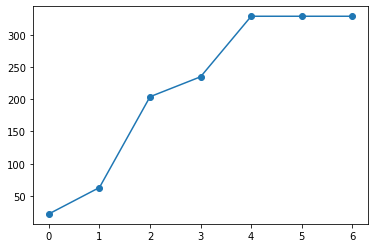

In [63]:
import matplotlib.pyplot as plt
X = count_freqs[0]
y = count_freqs[1]

plt.scatter(X,y)
plt.plot(X,y);

In [67]:
def plot_frequencies(x):
    count_freqs = np.array([
    range(7),
    [len(region_freq_ct[region_freq_ct[f'{x}'] > 0.01]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.005]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.001]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.0005]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.0001]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.00001]),
     len(region_freq_ct[region_freq_ct[f'{x}'] > 0.000001])]])
    
    X = count_freqs[0]
    y = count_freqs[1]
    print(f"Plot of {x} region")
    plt.scatter(X,y)
    plt.plot(X,y)
    plt.show();

Plot of Appohzarka region


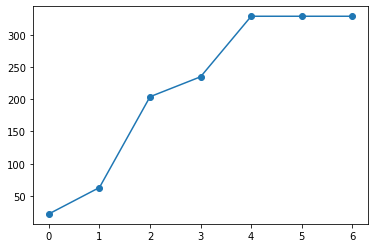

Plot of Deep South region


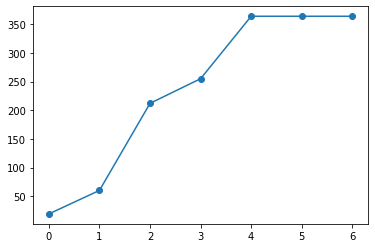

Plot of Great Lakes region


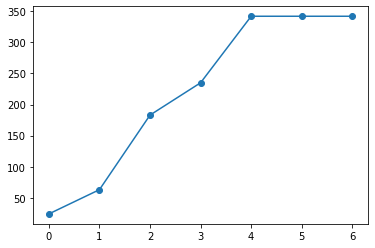

Plot of Great Plains region


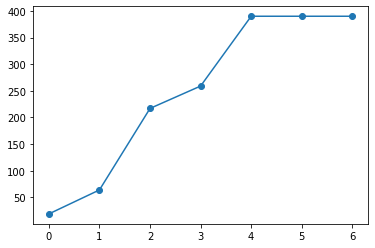

Plot of Gulf Coast region


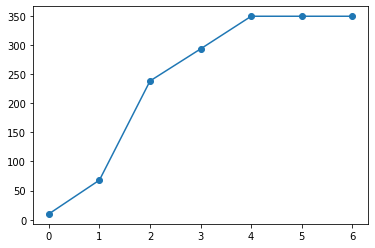

Plot of Heartland region


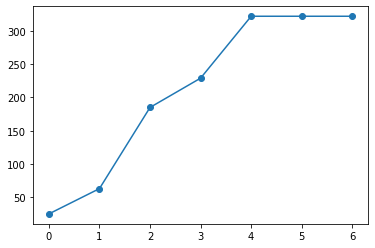

Plot of Mid-Atlantic North region


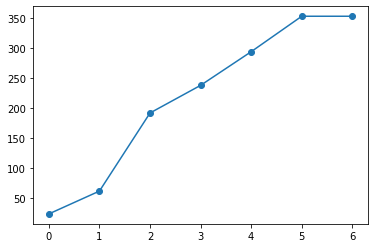

Plot of Mid-Atlantic South region


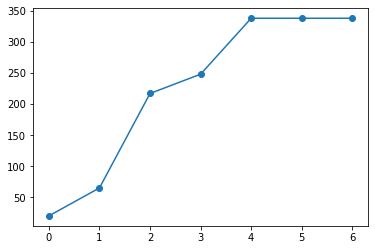

Plot of Mountain West region


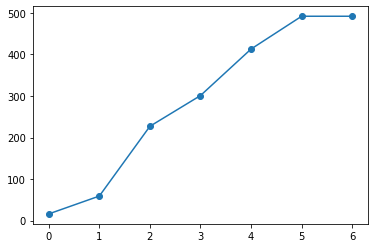

Plot of Northeast region


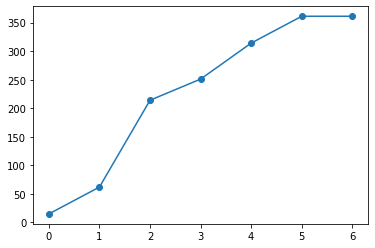

Plot of Northwest region


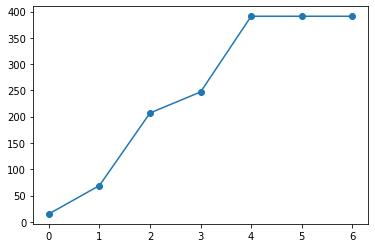

Plot of Southern Florida region


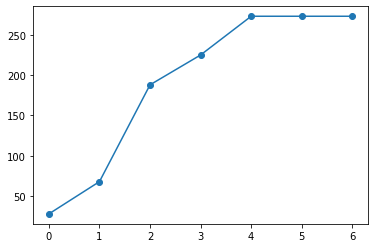

Plot of Southwest region


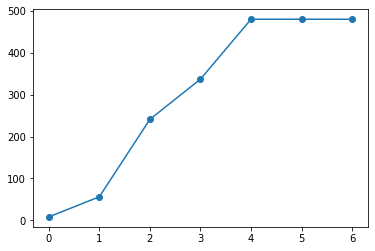

Plot of West Coast region


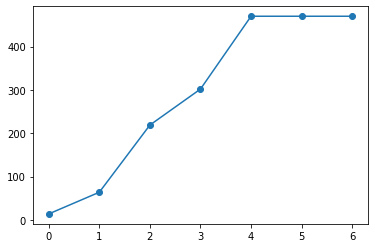

In [68]:
for column in region_freq_ct.columns:
    plot_frequencies(column)

In [349]:
merged.region_rarity.value_counts(normalize=True)

Uncommon    0.735038
Common      0.263196
Rare        0.001766
Name: region_rarity, dtype: float64

In [340]:
region_freq_ct

RegionName,Appohzarka,Deep South,Great Lakes,Great Plains,Gulf Coast,Heartland,Mid-Atlantic North,Mid-Atlantic South,Mountain West,Northeast,Northwest,Southern Florida,Southwest,West Coast
name,,,,,,,,,,,,,,
Abert's Towhee,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004802,0.000406
Acadian Flycatcher,0.002703,0.001910,0.001307,0.000000,0.001538,0.000832,0.000950,0.001998,0.000000,0.000000,0.000000,0.001067,0.000424,0.000000
Accipiter sp.,0.000118,0.000112,0.000218,0.000218,0.000000,0.000000,0.000086,0.000000,0.000198,0.000284,0.000119,0.000000,0.000141,0.000000
Acorn Woodpecker,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001782,0.000000,0.003446,0.000000,0.005366,0.004331
African Collared-Dove (Domestic type or Ringed Turtle-Dove),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000141,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
warbler sp. (Parulidae sp.),0.000118,0.000000,0.000109,0.000218,0.000000,0.000000,0.000173,0.000222,0.000198,0.000379,0.000000,0.000000,0.000000,0.000000
white egret sp.,0.000000,0.000000,0.000000,0.000000,0.000256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
woodpecker sp.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000086,0.000000,0.000198,0.000000,0.000000,0.000000,0.000000,0.000000


In [281]:
region_freq_ct.loc['white egret sp.']

RegionName
Appohzarka            0.000000
Deep South            0.000000
Great Lakes           0.000000
Great Plains          0.000000
Gulf Coast            0.000256
Heartland             0.000000
Mid-Atlantic North    0.000000
Mid-Atlantic South    0.000000
Mountain West         0.000000
Northeast             0.000000
Northwest             0.000000
Southern Florida      0.000000
Southwest             0.000000
West Coast            0.000000
Name: white egret sp., dtype: float64

In [275]:
merged.query("name == 'Magnolia Warbler'")

,name,observ_count,country,state,county,latitude,longitude,observ_date,year,month,...,CountyName,CountyFIPS,Region,RegionName,DensityCat,DensityCatName,Population2016,Density2016_SqMi,Density2016_PFbF,DensityAggreg
0,Magnolia Warbler,2,United States,Illinois,Cook,41.775629,-87.583273,1995-08-27,1995,8,...,Cook,17031,8,Great Lakes,1,1 Urban,5203499,13472.458286,27.835658,100
42,Magnolia Warbler,1,United States,Illinois,Cook,41.850030,-87.650050,1972-09-24,1972,9,...,Cook,17031,8,Great Lakes,1,1 Urban,5203499,13472.458286,27.835658,100
1194,Magnolia Warbler,1,United States,Illinois,Cook,41.943561,-87.636194,1978-05-11,1978,5,...,Cook,17031,8,Great Lakes,1,1 Urban,5203499,13472.458286,27.835658,100
3280,Magnolia Warbler,2,United States,Maryland,Carroll,39.397850,-76.986394,1979-10-13,1979,10,...,Carroll,24013,6,Mid-Atlantic North,3,3 Rural/Semi-Rural,167656,843.754594,1.743295,100
5144,Magnolia Warbler,1,United States,Indiana,Allen,41.021582,-85.239304,1997-06-05,1997,6,...,Allen,18003,8,Great Lakes,2,2 Medium-Urban,370404,2344.592349,4.844199,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102375,Magnolia Warbler,2,United States,Texas,Lee,30.418809,-97.157266,1981-05-06,1981,5,...,Lee,48287,10,Great Plains,3,3 Rural/Semi-Rural,17055,91.635102,0.189329,100
102474,Magnolia Warbler,2,United States,Texas,Lee,30.418809,-97.157266,1996-05-09,1996,5,...,Lee,48287,10,Great Plains,3,3 Rural/Semi-Rural,17055,91.635102,0.189329,100
103330,Magnolia Warbler,6,United States,Georgia,Greene,33.718567,-83.300112,1999-09-26,1999,9,...,Greene,13133,1,Deep South,3,3 Rural/Semi-Rural,17003,69.882586,0.144386,100
103836,Magnolia Warbler,6,United States,Virginia,York,37.219120,-76.403046,1993-05-16,1993,5,...,York,51199,5,Mid-Atlantic South,2,2 Medium-Urban,67976,1921.142130,3.969302,129
